In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
import sys
sys.path.append('/home/coolshan/Project/Efficient-Pytorch-Template')
from efficient.ml_model import *
from efficient.utils import *
from efficient.eval_utils import *

data_df = pd.read_excel('data/train.xlsx')
test_df = pd.read_excel('data/test.xlsx')
submission_df = pd.read_csv('data/submission.csv')

In [2]:
data = data_df.values[:,:-1]
label=data_df.values[:,-1]
qt = QuantileTransformer(n_quantiles=100)
data = qt.fit_transform(data)

In [3]:
# split 9:1 
train_data, train_label, test_data, test_label = KFold_Sampler(data,label,n_splits=100).get_multi_fold_data(n_fold=10)
print(len(train_data),len(test_data),len(test_data)/(len(train_data)+len(test_data)))

# define model list
model_lgb = lgb.LGBMClassifier(is_unbalance=True)

model_dict = {'RF_3':RandomForestClassifier(n_estimators=310,max_depth=3),
              'RF_depth_None':RandomForestClassifier(n_estimators=310),
              'XGB_31_3':XGBClassifier(n_estimators=31,max_depth=3),
              'XGB_310_3':XGBClassifier(n_estimators=31,max_depth=3),
              'XGB_31':XGBClassifier(n_estimators=31),
              'XGB_310':XGBClassifier(n_estimators=310),
              'SVM':SVC(probability=True),
              'SVM_lin':SVC(kernel='linear',probability=True),
              'SVM_rbf':SVC(kernel='rbf',probability=True),
              'SVM_0.2':SVC(C=0.2,probability=True),
              'SVM_0.2_lin':SVC(C=0.2,kernel='linear',probability=True),
              'SVM_0.2_poly':SVC(C=0.2,kernel='poly',probability=True),
              'SVM_5':SVC(C=5,probability=True),
              'SVM_5_lin':SVC(C=5,kernel='linear',probability=True),
              'SVM_5_poly':SVC(C=5,kernel='poly',probability=True),
              # 'KNN_Cls':KNeighborsClassifier(),
              'LGB_Cls':model_lgb,
              # 'Ridge_Cls':RidgeClassifier(),
              # 'MLP_Cls':MLPClassifier(activation = "relu", alpha = 0.001, hidden_layer_sizes = (56,10),
              #               learning_rate = "constant", max_iter = 3000, random_state = 3000,early_stopping=True),
              # 'QDA':QuadraticDiscriminantAnalysis(),
              }
#stack_model=MLPClassifier(activation = "relu", alpha = 0.0001,validation_fraction=0.1, hidden_layer_sizes = (38),learning_rate = "constant", max_iter = 3000, random_state = 1000,early_stopping=True)
# stack_model=SVC(C=1,kernel='linear', probability=True)
#stack_model = DecisionTreeClassifier()
model = Stack_Ensemble_Proba_Model(copy.deepcopy(model_dict),stack_model=ML_Weighted_Model(len(list(model_dict.keys())),2,
                                                                                                     model_reg=0.00,
                                                                                                     classes_reg=0.00,
                                                                                                     l1_norm=0.00),stack_training_split=0.2)
# model = Mean_Ensemble_Proba_Model(copy.deepcopy(model_dict))
cv_model, cv_df = model.cross_validation_evaluate(train_data, train_label, accuracy_score,n_splits=5)

3510 393 0.10069177555726365


Parameter containing:
tensor([[0.0000, 0.0000],
        [0.9655, 0.9655],
        [0.8162, 0.8162],
        [0.8162, 0.8162],
        [1.0851, 1.0851],
        [1.0993, 1.0993],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.3301, 0.3301],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0788, 1.0788]], requires_grad=True)




====== CV:0 ======
             model  eval_metric
0             RF_3     0.675214
1      SVM_0.2_lin     0.686610
2        SVM_5_lin     0.689459
3          SVM_lin     0.689459
4          SVM_0.2     0.695157
5          XGB_310     0.707977
6     SVM_0.2_poly     0.716524
7       SVM_5_poly     0.720798
8          LGB_Cls     0.727920
9           XGB_31     0.730769
10         SVM_rbf     0.733618
11             SVM     0.733618
12       XGB_310_3     0.735043
13        XGB_31_3     0.735043
14   RF_depth_None     0.747863
15  Ensemble Model     0.757835
16           SVM_5     0.762108


Parameter containing:
tensor([[0.0000, 0.0000],
        [1.0339, 1.0339],
        [0.5275, 0.5275],
        [0.5275, 0.5275],
        [1.0759, 1.0759],
        [1.0989, 1.0989],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.3650, 0.3650],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0825, 1.0825]], requires_grad=True)




====== CV:1 ======
             model  eval_metric
0             RF_3     0.665242
1      SVM_0.2_lin     0.672365
2          SVM_0.2     0.673789
3        SVM_5_lin     0.679487
4          SVM_lin     0.679487
5         XGB_31_3     0.695157
6        XGB_310_3     0.695157
7          LGB_Cls     0.696581
8     SVM_0.2_poly     0.698006
9          XGB_310     0.699430
10      SVM_5_poly     0.703704
11         SVM_rbf     0.705128
12             SVM     0.705128
13          XGB_31     0.709402
14           SVM_5     0.710826
15  Ensemble Model     0.722222
16   RF_depth_None     0.729345


Parameter containing:
tensor([[0.0000, 0.0000],
        [0.8753, 0.8753],
        [0.9362, 0.9362],
        [0.9362, 0.9362],
        [1.0453, 1.0453],
        [1.0985, 1.0985],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.8147, 0.8147],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0536, 1.0536]], requires_grad=True)




====== CV:2 ======
             model  eval_metric
0             RF_3     0.656695
1          SVM_0.2     0.689459
2          SVM_lin     0.692308
3        SVM_5_lin     0.693732
4      SVM_0.2_lin     0.696581
5       SVM_5_poly     0.700855
6           XGB_31     0.707977
7          LGB_Cls     0.710826
8     SVM_0.2_poly     0.717949
9          XGB_310     0.719373
10         SVM_rbf     0.722222
11             SVM     0.723647
12       XGB_310_3     0.725071
13           SVM_5     0.725071
14        XGB_31_3     0.725071
15  Ensemble Model     0.736467
16   RF_depth_None     0.747863


Parameter containing:
tensor([[0.0000, 0.0000],
        [0.4052, 0.4052],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0977, 1.0977],
        [1.1112, 1.1112],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.9981, 0.9981],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0814, 1.0814]], requires_grad=True)




====== CV:3 ======
             model  eval_metric
0          SVM_lin     0.659544
1      SVM_0.2_lin     0.660969
2        SVM_5_lin     0.662393
3             RF_3     0.683761
4          SVM_0.2     0.686610
5     SVM_0.2_poly     0.692308
6              SVM     0.700855
7          SVM_rbf     0.702279
8        XGB_310_3     0.712251
9         XGB_31_3     0.712251
10      SVM_5_poly     0.712251
11         XGB_310     0.723647
12   RF_depth_None     0.729345
13           SVM_5     0.732194
14         LGB_Cls     0.735043
15  Ensemble Model     0.740741
16          XGB_31     0.743590


Parameter containing:
tensor([[0.0000, 0.0000],
        [0.9736, 0.9736],
        [0.9596, 0.9596],
        [0.9596, 0.9596],
        [1.0592, 1.0592],
        [1.0945, 1.0945],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.6430, 0.6430],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0468, 1.0468]], requires_grad=True)




====== CV:4 ======
             model  eval_metric
0      SVM_0.2_lin     0.658120
1             RF_3     0.666667
2          SVM_lin     0.666667
3        SVM_5_lin     0.678063
4          SVM_0.2     0.693732
5     SVM_0.2_poly     0.700855
6       SVM_5_poly     0.705128
7          SVM_rbf     0.705128
8              SVM     0.706553
9          LGB_Cls     0.712251
10           SVM_5     0.713675
11          XGB_31     0.717949
12       XGB_310_3     0.720798
13        XGB_31_3     0.720798
14  Ensemble Model     0.720798
15   RF_depth_None     0.723647
16         XGB_310     0.726496

====== CV Mean ======
             model  eval_metric
0             RF_3     0.669516
1      SVM_0.2_lin     0.674929
2          SVM_lin     0.677493
3        SVM_5_lin     0.680627
4          SVM_0.2     0.687749
5     SVM_0.2_poly     0.705128
6       SVM_5_poly     0.708547
7          SVM_rbf     0.713675
8              SVM     0.713960
9          XGB_310     0.715385
10         LGB_Cls     0.716

array([0.       , 0.8506971, 0.6479019, 0.6479019, 1.0726264, 1.1005089,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.6301796, 0.       , 0.       , 1.0686307], dtype=float32)

['RF_3',
 'RF_depth_None',
 'XGB_31_3',
 'XGB_310_3',
 'XGB_31',
 'XGB_310',
 'SVM',
 'SVM_lin',
 'SVM_rbf',
 'SVM_0.2',
 'SVM_0.2_lin',
 'SVM_0.2_poly',
 'SVM_5',
 'SVM_5_lin',
 'SVM_5_poly',
 'LGB_Cls']

array([[0.  , 0.  ],
       [0.85, 0.85],
       [0.65, 0.65],
       [0.65, 0.65],
       [1.07, 1.07],
       [1.1 , 1.1 ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.63, 0.63],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [1.07, 1.07]], dtype=float32)

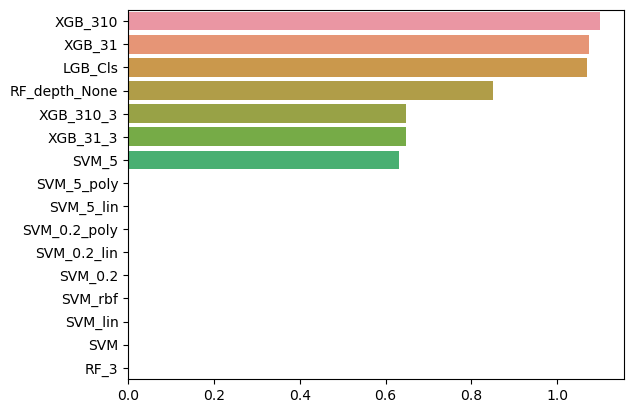

In [4]:
weights = cv_model[0].stack_model.weights.data.detach().numpy()
for i in range(1,len(cv_model)):
  weights = np.add(cv_model[i].stack_model.weights.data.detach().numpy(),weights)

weights = weights/len(cv_model)
importance = np.array(weights.mean(axis=1))
model_name = list(model_dict.keys())
display(importance,model_name)
display(np.round(weights,decimals=2))
zipped = list(zip(model_name,importance))
sorted_zipped = sorted(zipped, key=lambda x: x[1])[::-1]
model_name, importance = zip(*sorted_zipped)
importance = np.array(importance)
sns.barplot(y=list(model_name),x=importance)
plt.show()

In [ ]:
stack_model = ML_Weighted_Model(5,2,epoch=10000,init_mode='rand',l1_norm=0)

In [ ]:

#stack_model = DecisionTreeClassifier()
cv_ensemble_model = Stack_Ensemble_Proba_Model(model_dict=cv_model, stack_model=copy.deepcopy(stack_model), stack_training_split=0.3)
# cv_ensemble_model = Mean_Ensemble_Proba_Model(cv_model)
cv_ensemble_model.fit(train_data,train_label)
# # cv_ensemble_model.fit(train_data,train_label)
# print('========== Ensemble Model ==========')
# _=model.evaluate(test_data,test_label,evaluation_fn=accuracy_score,verbose=True)
print('========== CV Ensemble Model ==========')
_=cv_ensemble_model.evaluate(test_data,test_label,evaluation_fn=accuracy_score,verbose=True)

In [ ]:
cv_ensemble_model.evaluate(train_data,train_label,accuracy_score)

In [ ]:
test_data = test_df.values[:,1:]
test_data = qt.transform(test_data)
test_pred = model.predict(test_data)
test_pred

In [ ]:
import torch